# Recurrent Neural Networks

In our [previous MLP experiment](./03-mlp.ipynb), we saw that a neural network could extract more from averaged word embeddings than a simple Logistic Regression. However, averaging throws away crucial information - the order of words in a sentence.

This time, we are going to dive deeper into **recurrent neural networks**. They are specifically designed to process sequences, remembering context and understanding how word order contributes to meaning. Let's see if harnessing this sequential power can push our accuracy even further.

## Data Preparation

In [1]:
from datasets import load_dataset
train, test = load_dataset('stanfordnlp/imdb', split=['train', 'test'])
class_names = train.features['label'].names

x_train = train['text']
y_train = train['label']
x_test = test['text']
y_test = test['label']

## Data Encoding

In our previous notebook, we simply tokenized text and then immediately squashed it into the averaged word vectors. Our new recurrent pipeline needs to be a bit more complicated.

This time, we would simply **tokenize** our sentences first - without trying to vectorize them. We might limit the vocabulary, making it more robust and accurate representation of frequently occurring words by filtering out rare or noisy terms.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 45000
tokenizer = Tokenizer(num_words=max_vocab, oov_token='[OOV]')

tokenizer.fit_on_texts(x_train)
display(tokenizer.texts_to_sequences(['Hello World']))

[[4804, 180]]

Next, we need to **pad** our sequences. Most neural networks require input sequences to be of a uniform length. Since our sentences naturally vary, we need to bring them to the same length. 

This involves either truncating longer sequences or adding special tokens (usually zeros) to shorter sequences until they all reach a predetermined maximum length. Let's do a small research to determine how long our sequences usually are.

In [3]:
import matplotlib.pyplot as plt
text_lengths = train.to_pandas()['text'].apply(lambda x: len(x.split()))
display(text_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]))

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
95%        598.000000
99%        913.000000
max       2470.000000
Name: text, dtype: float64

Taking the top quartile length seems to be a reasonable choice here.

In [4]:
from tensorflow.keras.utils import pad_sequences

max_seq = 284
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_seq)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_seq)

display(x_train)
display(x_train.shape)

array([[    5,    30,     2, ...,     5,     4,   112],
       [    0,     0,     0, ...,     5,  5075,  2347],
       [    0,     0,     0, ...,  1785,     8,     8],
       ...,
       [    0,     0,     0, ...,   278,     4, 34503],
       [ 1600,     1,   762, ...,    17,     2,  9207],
       [    0,     0,     0, ..., 34515,    24,  3573]], dtype=int32)

(25000, 284)

## Embedding Layer

Finally, we need to transform these padded sequences into some meaningful representation that captures their semantic relationships. That's where the **embedding layer** comes in. To build it, we may utilize our existing pre-trained model.

In [5]:
from os import path
from huggingface_hub import snapshot_download
from gensim.models import KeyedVectors

model_path = path.join(snapshot_download('fse/word2vec-google-news-300'), 'word2vec-google-news-300.model')
wv = KeyedVectors.load(model_path)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Think of it as a sophisticated lookup table - for each token in our sequence, the embedding layer looks up its corresponding dense vector. This helps our neural network to capture not some random indexes, but the *semantic* meaning of words.

In [6]:
import numpy as np
embedding_matrix_shape = (max_vocab, wv.vector_size)
embedding_matrix = np.zeros(shape=embedding_matrix_shape)
for word, index in tokenizer.word_index.items():
    if index < max_vocab:
        if word in wv:
            embedding_matrix[index] = wv.get_vector(word)
        else:
            embedding_matrix[index] = np.zeros(wv.vector_size)

## Label Encoding

In [7]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=len(class_names))
y_test_encoded = to_categorical(y_test, num_classes=len(class_names))

## Building and Training the Model

Here comes the most interesting part. With our text now represented as sequences of dense semantic vectors (thanks to the embedding layer), we can introduce the star of this experiment - the **Long Short-Term Memory (LSTM)** layer.

Unlike a simple dense layer that processes all its inputs at once, an LSTM processes each vector in our sequence one at a time. Internally, each LSTM unit contains a sophisticated set of **gates** – an input gate, a forget gate, and an output gate – along with a memory cell.

These gates learn to control the flow of information, deciding what to remember from previous steps, what to discard, and what new information from the current word's vector is important enough to update its memory, allowing it to capture *context* and *dependencies* across the entire sequence.

We may also make the recurrent layer **bidirectional**, wrapping it in a special helper function - this will allow the network to capture information from both past and future time steps, leading to a more comprehensive understanding of the sequence.

In [8]:
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import layers, Sequential

num_classes = len(class_names)
set_random_seed(0)

model = Sequential([
    layers.Input(shape=(max_seq,)),
    layers.Embedding(
        weights=[embedding_matrix],
        input_dim=embedding_matrix_shape[0],
        output_dim=embedding_matrix_shape[1],
        trainable=False,
    ),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(256, dropout=0.2)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])

display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 284, 300)       │    13,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 284, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,641,762 (55.85 MB)

 Trainable params: 1,141,762 (4.36 MB)

 Non-trainable params: 13,500,000 (51.50 MB)

None

Before we start the training, we might tweak a few more things. Changing the optimizer learning rate may be a good idea - the default one might be too high when fine-tuning pre-trained embeddings.

In [9]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

Also, we might introduce a **learning rate scheduler** callback - it automatically reduces the optimizer's learning rate when a monitored metric (like validation loss) stops improving for a specified number of epochs (patience limit). This helps the model escape local minima and fine-tune its weights more precisely.

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)
callbacks = [reduce_lr, earlystop]

Now, let's compile and train our final model. This time we might start using the GPU - our model is finally complex enough to leverage the parallelism it offers to speed up the training process.

In [11]:
from tensorflow import device
with device('/GPU'):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train_encoded, epochs=25, batch_size=64, callbacks=callbacks, validation_split=0.2) 

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.6946 - loss: 0.5841 - val_accuracy: 0.4838 - val_loss: 0.9356 - learning_rate: 0.0010
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.7470 - loss: 0.5189 - val_accuracy: 0.8330 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.7805 - loss: 0.4794 - val_accuracy: 0.7012 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.7788 - loss: 0.4878 - val_accuracy: 0.8148 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.7924 - loss: 0.4671 - val_accuracy: 0.7542 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.8172 - loss: 0.4047 - val_accuracy: 0.8682 - val_loss: 0.3523 - learning_rate: 0.0010
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.8

## Result

In [12]:
from sklearn.metrics import classification_report
with device('/GPU'):
    y_pred_probs = model.predict(x_test, verbose=False)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_encoded, axis=1)
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

         neg       0.92      0.85      0.89     12500
         pos       0.86      0.93      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



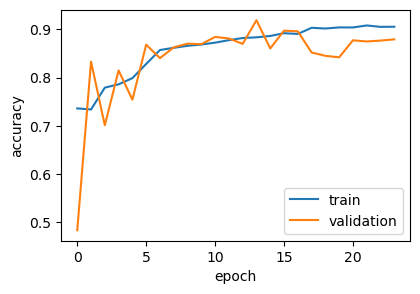

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Conclusion

We achieved a final accuracy of **89%**, ultimately outperforming the linear model. What is even more important - it's learning curve looks *much* healthier now. It became possible by combining LSTM units with pre-trained word embeddings, enabling the model to leverage sequential information.

This proves the value of sequence-aware models over simple embedding averaging for this type of task, performing competitively with the heavily optimized count vectorizer approach. Further improvements would require exploring more advanced architectures like transformers.